# Tutorial 1 : Thermomechanical Model


# A quick Lithospheric Model with visco-plastic non-linear rheologies

version 0.2
Romain Beucher
romain.beucher@unimelb.edu.au

The following tutorial presents a simple usage of the geodynamics module.
The *geodynamics* module intents to facilitate rapid prototyping of geodynamics models. It can be seen as a set of high-level functions within the underworld ecosystem. It is a means to quickly get the user into Underworld modelling and assumes very little knowledge in coding. The module make some assumptions based on how the user defines the boundary conditions and the properties of the materials (rocks, phases). 

Its simplicity comes with a relatively more rigid workflow (compared to the classic Underworld functions).
However, the user can easily break the high level objects and get back to core Underworld function at any step of model design. As we think the low-level interface is more flexible, and in so allows for more complex models, we strongly encourage users to explore and break the High Level functions. We hope that the user will naturally move to the low-level functionalities as he or her gets more confident, and by doing so will access the wide range of possibilities offered by Underworld.

![Tutorial 1](./images/Tutorial1.gif)


The module can be imported as follows:

In [1]:
import UWGeodynamics as GEO
import UWGeodynamics.visualisation as vis

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


# Working with units

Note that this is not an obligation and you can use values without units 


The geodynamics module enables usage of a broad range of units using a *UnitRegistry*. You can attach a unit to any value that you need to define. A value with a units attached becomes a *Quantity* python object. The geodynamics module take care of the conversion internally so you may use any units that you think are appropriate. You can also mix them.

The module will also try to work out a scaling of the values to help the computation process. The user can chose to alter the way his or her values are scaled or can rely on the default options.

To use the units system, you can link the unit registry as follow:

In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [4]:
Model = GEO.Model(elementRes=(128, 64), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir = "outputs_tutorial1"

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [6]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

The Model we are building is essentially a layered cake. The geodynamics module provide and easy way to define a layer by defining shape as *layer* and specifying its *top* and *bottom*. The order is important: when 2 shapes overlay each other, only the second is used.

In [7]:
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=2.0 * u.kilometer))
stickyAir = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer(top=air.bottom, bottom= 0.0 * u.kilometer))
crust = Model.add_material(name="Crust", shape=GEO.shapes.Layer(top=stickyAir.bottom, bottom=-35.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer(top=crust.bottom, bottom=-100.0 * u.kilometer))
mantle = Model.add_material(name="Mantle", shape=GEO.shapes.Layer(top=mantleLithosphere.bottom, bottom=Model.bottom))

In [8]:
air.diffusivity = 1.0e-6 * u.metre**2 / u.second
stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second

air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [9]:
air.density = 1. * u.kilogram / u.metre**3
stickyAir.density = 1. * u.kilogram / u.metre**3
crust.density = GEO.LinearDensity(2620. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantleLithosphere.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)
mantle.density = GEO.LinearDensity(3370. * u.kilogram / u.metre**3, thermalExpansivity=3e-5 / u.kelvin)

In [10]:
crust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [11]:
rh = GEO.ViscousCreepRegistry()

In [12]:
Model.minViscosity = 1e18 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second

air.viscosity                = 1e19 * u.pascal * u.second
stickyAir.viscosity          = 1e20 * u.pascal * u.second
crust.viscosity              = rh.Wet_Quartz_Dislocation_Gleason_and_Tullis_1995
mantleLithosphere.viscosity  = rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993
mantle.viscosity             = 0.2 * rh.Dry_Olivine_Dislocation_Karato_and_Wu_1993

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [13]:
pl = GEO.PlasticityRegistry()

In [14]:
crust.plasticity              = pl.Huismans_et_al_2011_Crust
mantleLithosphere.plasticity  = pl.Huismans_et_al_2011_Crust
mantle.plasticity             = pl.Huismans_et_al_2011_Crust

In [15]:
air

In [16]:
crust

## Temperature Boundary Conditions

In [17]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK), (stickyAir, 293.15 * u.degK)])

## Velocity Boundary Conditions

In [18]:
Model.set_velocityBCs(left=[-2.5 * u.centimeter / u.year, None],
                       right=[2.5 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=mantle, average=True))

## Initialize plastic strain

In [19]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))


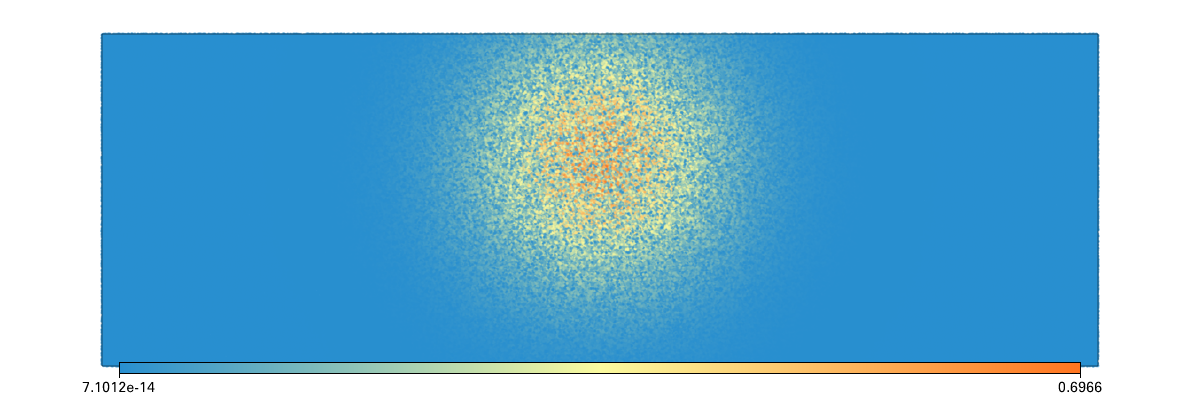

In [20]:
Fig = vis.Figure(figsize=(1200, 400))
Fig.Points(Model.swarm, Model.plasticStrain, fn_size=4.0)
Fig.show()

# Passive Tracers

### Single tracer

We create a single tracer that we place at the surface, in a central position. 

In [21]:
x = (Model.maxCoord[0] - Model.minCoord[0]) / 2.0 # This is the center of the model
y = 0.0 # The point is located at the surface, initially set at 0.

central_tracer = Model.add_passive_tracers(name="central", vertices=[x,y])

### Interface tracers

We add 2 sets of tracers for tracking the interface at the surface and the moho.

In [22]:
import numpy as np

npoints = 1000 # This is the number of points used to define the surface
x = np.linspace(GEO.nd(Model.minCoord[0]), GEO.nd(Model.maxCoord[0]), npoints) * u.kilometer
y = 0. * u.kilometer

surface_tracers = Model.add_passive_tracers(name="Surface", vertices=[x,y])
moho_tracers = Model.add_passive_tracers(name="Moho", vertices=[x,y-35.*u.kilometer])

### Grid Tracers

In [23]:
x_c, y_c = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], crust.bottom], 
                    maxCoord=[Model.maxCoord[0], 0.*u.kilometer])

FSE_Crust = Model.add_passive_tracers(name="FSE_Crust", vertices=[x_c, y_c])

x_m, y_m = GEO.circles_grid(radius=2.0*u.kilometer, 
                    minCoord=[Model.minCoord[0], mantleLithosphere.bottom], 
                    maxCoord=[Model.maxCoord[0], mantleLithosphere.top])

FSE_Mantle = Model.add_passive_tracers(name="FSE_Mantle", vertices=[x_m, y_m])


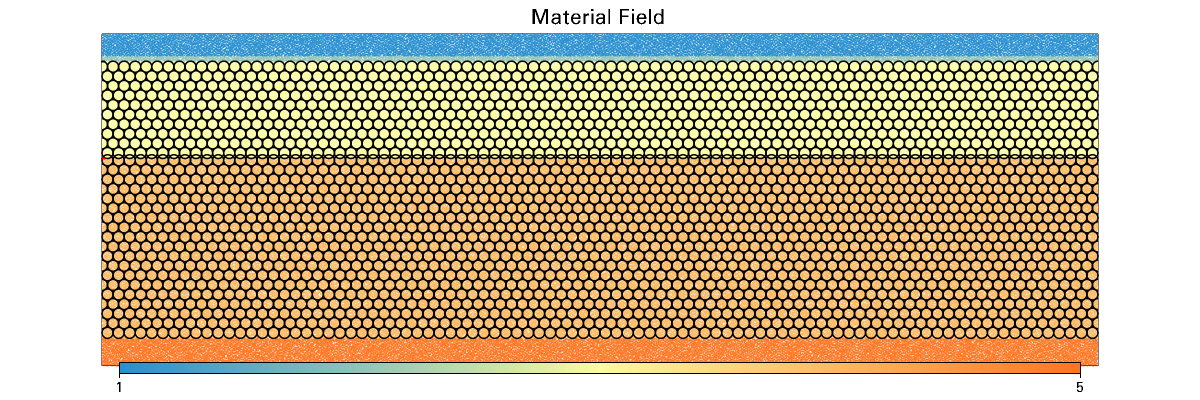

In [26]:
Fig = vis.Figure(figsize=(1200,400), title="Material Field", quality=2)
Fig.Points(surface_tracers, pointSize=2.0)
Fig.Points(moho_tracers, pointSize=2.0, colour="red")
Fig.Points(FSE_Crust, pointSize=2.0)
Fig.Points(FSE_Mantle, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Compute initial condition

In [27]:
Model.init_model()

/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)



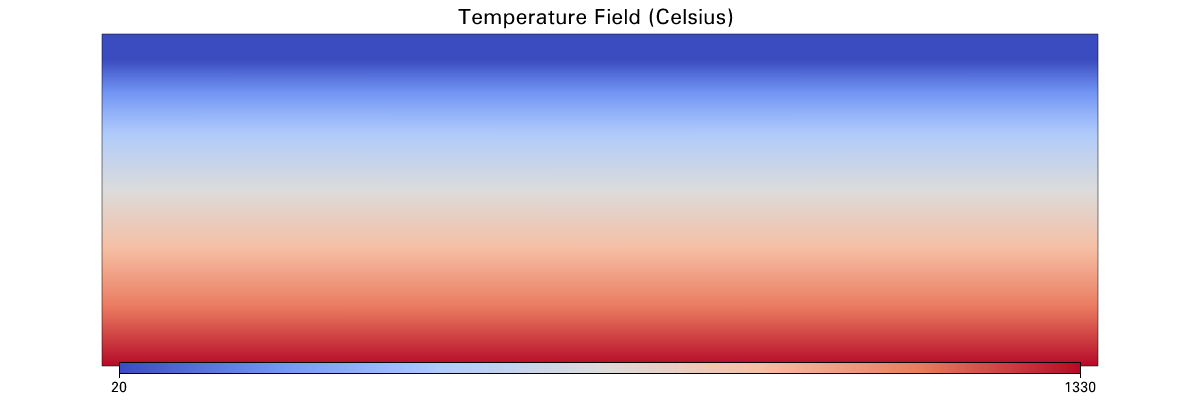

In [28]:
Fig = vis.Figure(figsize=(1200,400), title="Temperature Field (Celsius)", quality=3)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.temperature, u.degC), colours="coolwarm")
Fig.show()


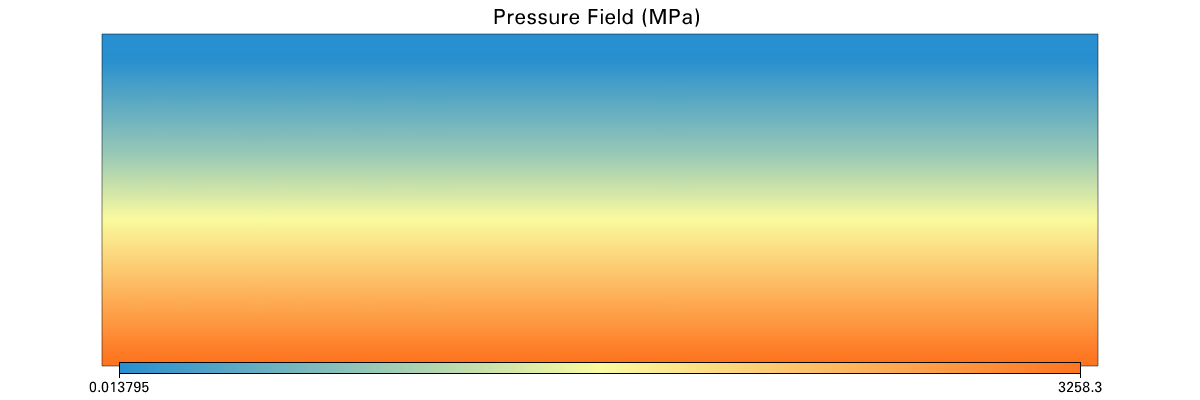

In [29]:
Fig = vis.Figure(figsize=(1200,400), title="Pressure Field (MPa)", quality=3)
Fig.Surface(Model.mesh, GEO.dimensionalise(Model.pressureField, u.megapascal))
Fig.show()

## Basic Analysis of the initial set-up

Let's analyze the pressure and temperature field by creating a vertical profile at the center of the model.

In [30]:
# Only run this when in serial. Will fail in parallel

if GEO.nProcs == 1:

    import matplotlib.pyplot as plt

    moho_average_temperature = Model.temperature.evaluate(moho_tracers).mean()
    moho_average_temperature = GEO.dimensionalise(moho_average_temperature, u.degC)

    print("Average Temperature at Moho: {0:5.0f}".format(moho_average_temperature))

    distances, temperature = GEO.extract_profile(Model.temperature, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, pressure = GEO.extract_profile(Model.pressureField, line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])

    Fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,7))
    ax1.plot(GEO.dimensionalise(temperature, u.degK), GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xlabel("Temperature in Kelvin")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(100, 0)
    ax1.set_title("Temperature profile")

    ax2.plot(GEO.dimensionalise(pressure, u.megapascal), GEO.dimensionalise(distances, u.kilometer))
    ax2.set_xlabel("Pressure in megapascal")
    ax2.set_ylabel("Depth in kms")
    ax2.set_title("Pressure profile")
    ax2.set_ylim(100, 0)
    plt.show()

Average Temperature at Moho: 558 degC


/usr/local/lib/python3.5/dist-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


<Figure size 1500x700 with 2 Axes>

In a similar fashion, one can extract a vertical profile of the viscosity field.


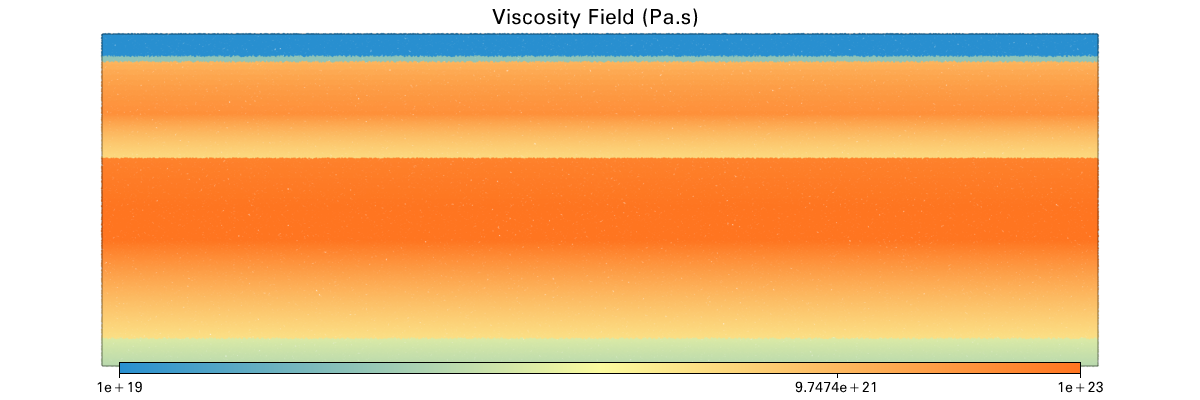

In [32]:
Fig = vis.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.show()

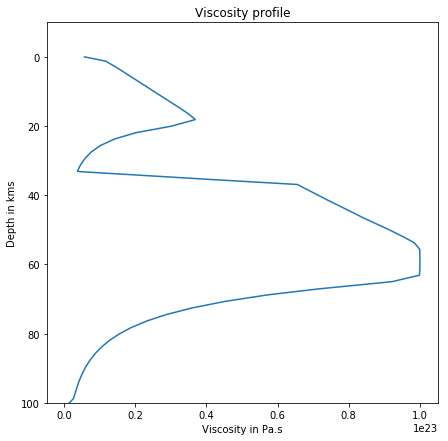

In [33]:
# Only run this when in serial. Will fail in parallel

if GEO.nProcs == 1:

    distances, viscosities = GEO.extract_profile(Model.projViscosityField, 
                                                 line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])
    distances, stresses = GEO.extract_profile(Model.projStressField, 
                                             line = [(180.* u.kilometer, 0.), (180.* u.kilometer, Model.bottom)])


    Fig, (ax1) = plt.subplots(1,1,figsize=(7,7))
    ax1.plot(GEO.dimensionalise(viscosities, u.pascal * u.second), GEO.dimensionalise(distances, u.kilometer))
    ax1.set_xlabel("Viscosity in Pa.s")
    ax1.set_ylabel("Depth in kms")
    ax1.set_ylim(100,-10)
    ax1.set_title("Viscosity profile")

## Solver options

In [34]:
Model.solver.set_inner_method("mumps")
Model.solver.set_penalty(1e6)
GEO.rcParams["initial.nonlinear.tolerance"] = 1e-4

# Run the Model

In [35]:
Model.run_for(nstep=2, checkpoint_interval=1)

Running with UWGeodynamics version 2.8.1-dev-38b7335(development)
Options:  -pc_type none -restore_K False -ksp_type bsscr -force_correction True -rescale_equations False -remove_constant_pressure_null_space False -Q22_pc_type gkgdiag -change_A11rhspresolve False -ksp_k2_type NULL -change_backsolve False -A11_pc_type lu -A11_ksp_type preonly -A11_pc_factor_mat_solver_package mumps -scr_ksp_type fgmres -scr_ksp_rtol 1e-05 -A11_mg_active False
Step:     1 Model Time: 32.53 kiloyear dt: 32.53 kiloyear (2019-03-15 05:48:29)
Step:     2 Model Time: 65.06 kiloyear dt: 32.53 kiloyear (2019-03-15 05:48:50)


1


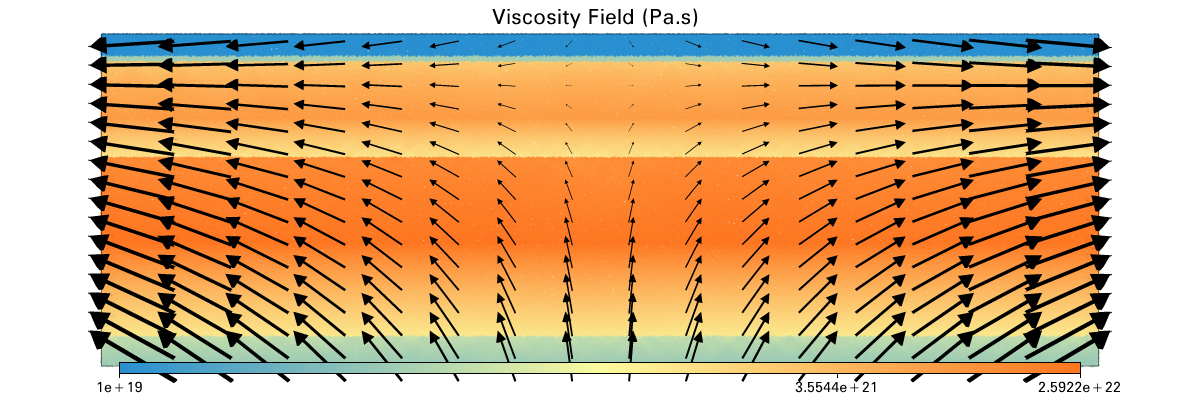

In [33]:
Fig = vis.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Points(Model.swarm, 
           GEO.dimensionalise(Model.viscosityField, u.pascal * u.second),
           logScale=True,
           fn_size=3.0)
Fig.VectorArrows(Model.mesh, Model.velocityField)
Fig.show()


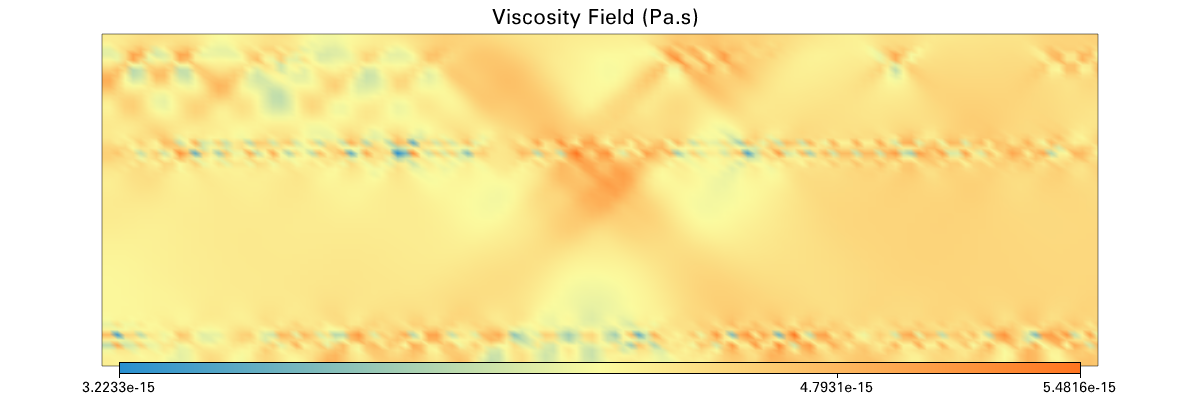

In [34]:
Fig = vis.Figure(figsize=(1200,400), title="Viscosity Field (Pa.s)", quality=3)
Fig.Surface(Model.mesh, 
           GEO.dimensionalise(Model.strainRateField, 1.0 / u.second),
           logScale=True)
Fig.show()